In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors=ap.COLORS

In [3]:
region="TWP"
chunk_dict={"time":50, "ncol":2000, "lev":50}

In [4]:
models=["SCREAM", "NICAM", "UM", "SAM", "GEOS"]

## create dictionaries with models as keys for each variable 
## cli = cloud ice, clw = cloud water, ta = temperature, hus = specific humidity
cli_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "cli")).cli.mean(axis=(0,2,3)) for m in models]))
clw_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "clw")).clw.mean(axis=(0,2,3)) for m in models]))
ta_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "ta")).ta.median(axis=(0,2,3)) for m in models]))
hus_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "hus")).hus.median(axis=(0,2,3)) for m in models]))
cl_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "cl")).cl.mean(axis=(0,2,3)) for m in models]))

## get snow and graupel for NICAM
clsg_ni = xr.open_dataset(ap.get_fldmean_file("NICAM", region, "snowmxrat")).snowmxrat.mean(axis=(0,2,3)) + \
       xr.open_dataset(ap.get_fldmean_file("NICAM", region, "grplmxrat")).grplmxrat.mean(axis=(0,2,3))
cls_ge = xr.open_dataset(ap.get_fldmean_file("GEOS", region, "snowmxrat")).snowmxrat.mean(axis=(0,2,3)) 
    # + \ xr.open_dataset(ap.get_fldmean_file("GEOS", region, "grplmxrat")).snowmxrat.mean(axis=(0,2,3))

## get total frozen hydrometeors
cli_dict["NICAM"] = cli_dict["NICAM"]+ clsg_ni
cli_dict["GEOS"]  = cli_dict["GEOS"] + cls_ge


## SAM has qv in g/kg - convert to kg/kg
hus_dict["SAM"] = hus_dict["SAM"]/1000

z_sc = xr.open_dataset(ap.get_fldmean_file("SCREAM","TWP","zg")).zg
z_um = xr.open_dataset(ap.get_fldmean_file("UM","TWP","zg")).zg
z_ge = xr.open_dataset(ap.get_fldmean_file("GEOS","TWP","zg")).zg.mean(axis=(0,2,3))
z_ni = ta_dict["NICAM"].lev.rename({"lev":"zg"})
z_sa = ta_dict["SAM"].z.rename({"z":"zg"})

z_dict = dict(zip(["SCREAM","NICAM","UM","SAM","GEOS"],[z_sc, z_ni, z_um, z_sa, z_ge]))

ds = xr.open_dataset("/work/bb1153/b380883/TWP/twp.nc")
cli_dict["DARDAR"] = ds.iwc.mean(axis=0)
cl_dict["DARDAR"] = np.where(ds.iwc>1e-2,1,0).mean(axis=0)
models=["DARDAR"]+models
z_dict["DARDAR"] = ds.height

ds = xr.open_dataset("/work/bb1153/b380883/TWP/CCCM_dTWP_2007-2010.nc")
cl_dict["CCCM"] = ds["Cloud fraction (CALIPSO-CloudSat)"].mean(axis=0)
cli_dict["CCCM"] = ds["iwc used in CERES radiation, avg over cloudy part of CERES footprint"].mean(axis=0)
clw_dict["CCCM"] = ds["lwc used in CERES radiation, avg over cloudy part of CERES footprint"].mean(axis=0)
models=["CCCM"]+models
z_dict["CCCM"] = ds.alt

big_dict = {"cli":cli_dict, "clw":clw_dict, "ta":ta_dict, "hus":hus_dict, "z":z_dict}


In [4]:
print(" model \t  14km \t \t  18km \t \t n")
print("-------------------------------------------------")

for m in models:
    if m=="CCCM":
        f = 1000
    else:
        f = 1
    z = z_dict[m].values
    i14 = np.argmin(abs(z*f-14000))
    i18 = np.argmin(abs(z*f-18000))
    print(m+"\t {} {:.2f} \t {} {:.2f} \t {}".format(i14, z[i14], i18, z[i18], i18-i14))
    

 model 	  14km 	 	  18km 	 	 n
-------------------------------------------------
CCCM	 22 13.92 	 5 18.00 	 -17
DARDAR	 185 13980.00 	 118 18000.00 	 -67
SCREAM	 47 13909.74 	 29 17910.05 	 -18
NICAM	 45 14183.80 	 55 18183.80 	 10
UM	 43 14079.88 	 49 18026.52 	 6
SAM	 49 13966.39 	 57 17966.39 	 8
GEOS	 103 13938.53 	 86 17907.57 	 -17


In [15]:
sc_iwc = xr.open_dataset(ap.get_fldmean_file("SCREAM","TWP","iwc")).pfull.mean(axis=(0,2,3))
um_iwc = xr.open_dataset(ap.get_fldmean_file("UM","TWP","iwc")).pfull.mean(axis=(0,2,3))


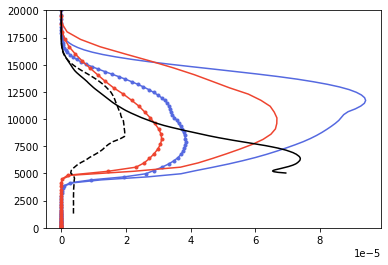

In [23]:
m="SCREAM"
plt.plot((cli_dict[m])[:-1], z_sc, color=colors[m])
plt.plot((sc_iwc)[:-1], z_sc, color=colors[m], marker=".", label=m)
m="UM"
plt.plot((cli_dict[m])[:-1], z_um, color=colors[m])
plt.plot((um_iwc)[:-1], z_um, color=colors[m], marker=".", label=m)

plt.plot((cli_dict["DARDAR"])[:335]/1000, z_dict["DARDAR"][:335], color=colors["OBS"], label="DARDAR")
plt.plot(cli_dict["CCCM"]/1000, (z_dict["CCCM"]*1000), color=colors["OBS"], label="CCCM", linestyle="--")
plt.ylim([0,20000])
plt.show()

## Cloud condensate

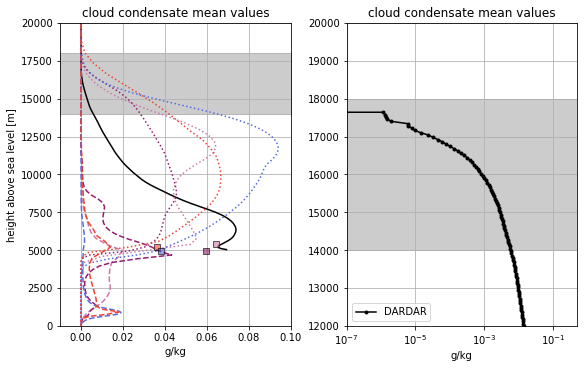

In [32]:

#### height given in file ####
cliw={}
fig, [ax, axt] = plt.subplots(1,2, figsize=(8,5), constrained_layout=True)
m="DARDAR"
z = "height"
ax.plot((cli_dict[m])[:335], z_dict[m][:335], color=colors["OBS"])
axt.plot((cli_dict[m])[:335], z_dict[m][:335], color=colors["OBS"], marker=".", label=m)

# m="SAM"
# z = "z"
# # clw_dict[m].plot(y=z, ax=ax, color=colors[m], linestyle="--")
# # cli_dict[m].plot(y=z, ax=ax, color=colors[m], linestyle=":")
# cliw[m] = (clw_dict[m]+cli_dict[m])
# cliw[m].plot(y=z, ax=ax, color=colors[m])
# cliw[m].plot(y=z, ax=axt, color=colors[m], marker=".", label=m+" cli (ice only)")

m="NICAM"
z = "lev"
((clw_dict[m])*1000).plot(y=z, ax=ax, color=colors[m], linestyle="--")
((cli_dict[m])*1000).plot(y=z, ax=ax, color=colors[m], linestyle=":")
cliw[m] = (clw_dict[m]+cli_dict[m])*1000
# cliw[m].plot(y=z, ax=ax, color=colors[m])
# cliw[m].plot(y=z, ax=axt, color=colors[m], marker=".", label=m)

### height from zg output ###
m="GEOS"
ax.plot((clw_dict[m]*1000), z_dict[m], color=colors[m], linestyle="--")
ax.plot((cli_dict[m]*1000), z_dict[m], color=colors[m], linestyle=":")
cliw[m] = (clw_dict[m]+cli_dict[m])*1000
# ax.plot((cliw[m]), z_ge, color=colors[m])
# axt.plot((cliw[m]), z_ge, color=colors[m], marker=".", label=m)

##### calculated height #####
m="SCREAM"
ax.plot((clw_dict[m]*1000)[:-1], z_dict[m], color=colors[m], linestyle="--")
ax.plot((cli_dict[m]*1000)[:-1], z_dict[m], color=colors[m], linestyle=":")
cliw[m] = (clw_dict[m]+cli_dict[m])*1000
# ax.plot((cliw[m])[:-1], z_dict[m], color=colors[m])
# axt.plot((cliw[m])[:-1], z_dict[m], color=colors[m], marker=".", label=m)

m="UM"
ax.plot((clw_dict[m]*1000)[:-1], z_dict[m], color=colors[m], linestyle="--")
ax.plot((cli_dict[m]*1000)[:-1], z_dict[m], color=colors[m], linestyle=":")
cliw[m] = (clw_dict[m]+cli_dict[m])*1000
# ax.plot(cliw[m][:-1], z_dict[m], color=colors[m])
# axt.plot(cliw[m][:-1], z_dict[m], color=colors[m], marker=".", label=m)

i_um = np.argmin(abs(ta_dict["UM"].values-273))
i_sc = np.argmin(abs(ta_dict["SCREAM"].values-273))
i_ni = np.argmin(abs(ta_dict["NICAM"].values-273))
i_sa = np.argmin(abs(ta_dict["SAM"].values-273))
i_ge = np.argmin(abs(ta_dict["GEOS"].values-273))

ax.scatter(cliw["UM"][i_um], z_um[i_um], color=colors["UM"], marker="s",
           alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cliw["NICAM"][i_ni], clw_dict["NICAM"].lev[i_ni], marker="s",
           color=colors["NICAM"], alpha=0.6, s=30, edgecolor="k", zorder=2)
# ax.scatter(cliw["SAM"][i_sa], clw_dict["SAM"].z[i_sa], color=colors["SAM"], 
#            marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cliw["SCREAM"][i_sc], z_sc[i_sc], color=colors["SCREAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cliw["GEOS"][i_ge], z_ge[i_ge], color=colors["GEOS"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)


ax.fill_between([-1e-2,1e-1],14000,18000,color="k",alpha=0.2)
ax.set_title("cloud condensate mean values")
ax.set_xlabel("g/kg")
ax.grid()
axt.fill_between([-1e-2,1],14000,18000,color="k",alpha=0.2)
axt.set_title("cloud condensate mean values")
axt.set_xlabel("g/kg")
axt.grid()

ax.set_xlim([-1e-2,1e-1])
ax.set_ylim([0,20000])

axt.legend(loc="lower left")
axt.set_xlim([1e-7,0.5])
axt.set_ylim([12000, 20000])
axt.set_xscale("log")
# plt.savefig("../plots/TWP/TWP_3D_cli+clw_mean.png", dpi=120)

plt.show()

# Cloud fraction

SCREAM uses 1e-5 kg/kg for their cloud mask - to be consistent we will use this as well.

In [26]:
cl_sc = xr.open_dataset("/work/bb1153/b380883/TWP/mean/fldmean_TWP_3D_SCREAM_cl_calculated1e-5_20200130-20200228.nc").cl.mean(axis=(0,2,3))
cl_ge = xr.open_dataset("/work/bb1153/b380883/TWP/mean/fldmean_TWP_3D_GEOS_cl_calculated1e-5_20200130-20200228.nc").cl.mean(axis=(0,2,3))

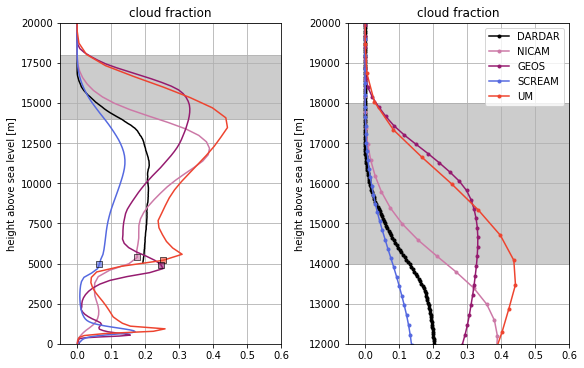

In [30]:
fig, [ax, axt] = plt.subplots(1,2, figsize=(8,5), constrained_layout=True)

#### height given in file ####
# m="SAM"
# z = "z"
# cl_dict[m].plot(y=z, ax=ax, color=colors[m])
# cl_dict[m].plot(y=z, ax=axt, color=colors[m], marker=".", label=m+" (ice only)")
m="DARDAR"
ax.plot(cl_dict[m][:335], z_da[:335], color=colors["OBS"])
axt.plot(cl_dict[m][:335], z_da[:335], color=colors["OBS"], marker=".", label=m)

m="CCCM"
ax.plot(cl_dict[m], z_da, color=colors["OBS"], linestyle="--")
axt.plot(cl_dict[m], z_da, color=colors["OBS"], marker=".", label=m, linestyle="--")

m="NICAM"
z = "lev"
cl_dict[m].plot(y=z, ax=ax, color=colors[m])
cl_dict[m].plot(y=z, ax=axt, color=colors[m], marker=".", label=m)

### height from zg output ###
m="GEOS"
ax.plot((cl_dict[m]), z_ge, color=colors[m])
axt.plot((cl_dict[m]), z_ge, color=colors[m], marker=".", label=m)
# ax.plot((cl_ge), z_ge, color=colors[m], linestyle="--")
# axt.plot((cl_ge), z_ge, color=colors[m], marker=".", label=m+" calc", linestyle="--")


##### calculated height #####
m="SCREAM"
ax.plot((cl_dict[m])[:-1], z_sc, color=colors[m])
axt.plot((cl_dict[m])[:-1], z_sc, color=colors[m], marker=".", label=m)
# ax.plot((cl_sc)[:-1], z_sc, color=colors[m], linestyle="--")
# axt.plot((cl_sc)[:-1], z_sc, color=colors[m], marker=".", label=m+" calc", linestyle="--")


m="UM"
ax.plot(cl_dict[m][:-1], z_um, color=colors[m])
axt.plot(cl_dict[m][:-1], z_um, color=colors[m], marker=".", label=m)

i_um = np.argmin(abs(ta_dict["UM"].values-273))
i_sc = np.argmin(abs(ta_dict["SCREAM"].values-273))
i_ni = np.argmin(abs(ta_dict["NICAM"].values-273))
i_sa = np.argmin(abs(ta_dict["SAM"].values-273))
i_ge = np.argmin(abs(ta_dict["GEOS"].values-273))

ax.scatter(cl_dict["UM"][i_um], z_um[i_um], color=colors["UM"], marker="s",
           alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cl_dict["NICAM"][i_ni], cl_dict["NICAM"].lev[i_ni], marker="s",
           color=colors["NICAM"], alpha=0.6, s=30, edgecolor="k", zorder=2)
# ax.scatter(cl_dict["SAM"][i_sa], cl_dict["SAM"].z[i_sa], color=colors["SAM"], 
           # marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cl_dict["SCREAM"][i_sc], z_sc[i_sc], color=colors["SCREAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cl_dict["GEOS"][i_ge], z_ge[i_ge], color=colors["GEOS"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)


ax.fill_between([-0.1,0.6],14000,18000,color="k",alpha=0.2)
ax.set_title("cloud fraction")
ax.set_xlabel("")
ax.grid()
axt.fill_between([-1,0.6],14000,18000,color="k",alpha=0.2)
axt.set_title("cloud fraction")
axt.set_xlabel("")
axt.grid()

ax.set_xlim([-0.05,0.6])
ax.set_ylim([0,20000])

axt.legend(loc="upper right")
axt.set_xlim([-0.05,0.6])
axt.set_ylim([12000, 20000])
plt.savefig("../plots/TWP/TWP_3D_cl.png", dpi=120)

plt.show()

0 SCREAM 0.2
1 NICAM 1
2 UM 0.2
3 SAM 0.2
4 GEOS 0.2
5 DARDAR 0.2
6 CCCM 0.2


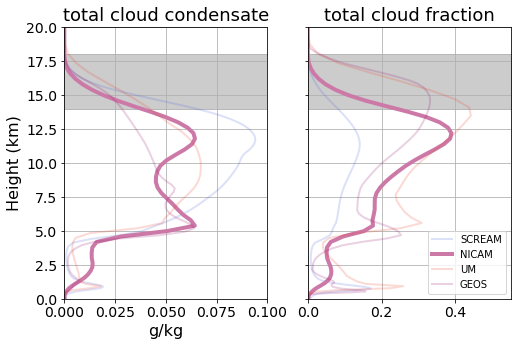

In [38]:
fig, ax = plt.subplots(1,2, figsize=(8,5), sharey=True)
fs=18
ma="NICAM"
for i,m in enumerate(list(cli_dict.keys())):
    if ma!="all":
        if m==ma:
            a = 1
            lw=4
        else:
            a = 0.2
            lw=2
    else:
        a=1
        lw=3
    print(i,m, a)
    if m=="DARDAR":
        continue
        ax[0].plot(cli_dict[m][:335], (z_dict[m]/1000)[:335], color=colors["OBS"], lw=lw)
        ax[1].plot(cl_dict[m][:335], (z_dict[m]/1000)[:335], color=colors["OBS"], lw=lw, label=m)
    elif m=="CCCM":
        continue
        ax[0].plot((cli_dict[m]+clw_dict[m]), (z_dict[m]), color=colors["OBS"], lw=lw, linestyle="--")
        ax[1].plot(cl_dict[m], (z_dict[m]), color=colors["OBS"], lw=lw, label=m, linestyle="--")
    elif m=="SAM":
        continue
    elif m=="SCREAM" or m=="UM":
        ax[0].plot(1000*(cli_dict[m]+clw_dict[m])[:-1], z_dict[m]/1000, color=colors[m], lw=lw, alpha=a)
        ax[1].plot(cl_dict[m][:-1], z_dict[m]/1000, color=colors[m], lw=lw, label=m, alpha=a)
    else:
        ax[0].plot(1000*(cli_dict[m]+clw_dict[m]), z_dict[m]/1000, color=colors[m], lw=lw, alpha=a)
        ax[1].plot(cl_dict[m], z_dict[m]/1000, color=colors[m], lw=lw, label=m, alpha=a)
ax[1].legend()
ax[0].set_title("total cloud condensate", fontsize=fs)
ax[1].set_title("total cloud fraction", fontsize=fs)
ax[0].set_ylabel("Height (km)", fontsize=fs-2)
ax[0].set_xlabel("g/kg", fontsize=fs-2)
ax[0].tick_params(axis="both", labelsize=fs-4)
ax[1].tick_params(axis="both", labelsize=fs-4)
ax[0].set_ylim([0,20])
ax[0].fill_between([-0.1,0.6],14,18,color="k",alpha=0.2)
ax[1].fill_between([-0.1,0.6],14,18,color="k",alpha=0.2)
ax[0].set_xlim([0,0.1])
ax[1].set_xlim([0,0.55])
ax[0].grid()
ax[1].grid()
plt.savefig("../plots/TWP/TWP_3D_cli_cl_{}.png".format(ma),dpi=150)
plt.show()


## Temperature

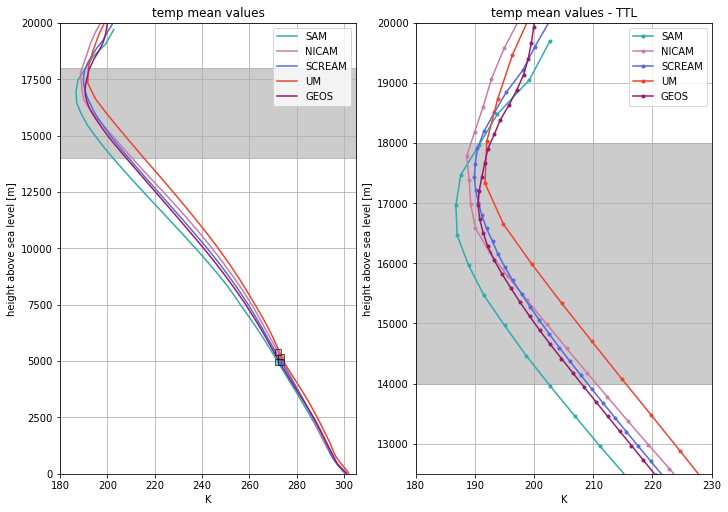

In [26]:
fig, [ax, axt] = plt.subplots(1,2, figsize=(10,7), constrained_layout=True)
m="SAM"
z = "z"
(ta_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(ta_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="NICAM"
z = "lev"
(ta_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(ta_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="SCREAM"
z = "lev"
ax.plot((ta_dict[m])[:-1], z_sc, color=colors[m], label=m)
axt.plot((ta_dict[m])[:-1], z_sc, color=colors[m], label=m, marker=".")
m="UM"
ax.plot(ta_dict[m][:-1], z_um, color=colors[m], label=m)
axt.plot(ta_dict[m][:-1], z_um, color=colors[m], label=m, marker=".")
m="GEOS"
ax.plot(ta_dict[m], z_ge, color=colors[m], label=m)
axt.plot(ta_dict[m], z_ge, color=colors[m], label=m, marker=".")

i_um = np.argmin(abs(ta_dict["UM"].values-273))
i_sc = np.argmin(abs(ta_dict["SCREAM"].values-273))
i_ni = np.argmin(abs(ta_dict["NICAM"].values-273))
i_sa = np.argmin(abs(ta_dict["SAM"].values-273))
i_ge = np.argmin(abs(ta_dict["GEOS"].values-273))

ax.scatter(ta_dict["UM"][i_um], z_um[i_um], color=colors["UM"], marker="s",
           alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(ta_dict["NICAM"][i_ni], clw_dict["NICAM"].lev[i_ni], marker="s",
           color=colors["NICAM"], alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(ta_dict["SAM"][i_sa], clw_dict["SAM"].z[i_sa], color=colors["SAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(ta_dict["SCREAM"][i_sc], z_sc[i_sc], color=colors["SCREAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)


ax.fill_between([180,305],14000,18000,color="k",alpha=0.2)
axt.fill_between([180,305],14000,18000,color="k",alpha=0.2)


ax.legend(loc="upper right")
axt.legend(loc="upper right")
ax.set_xlim([180,305])
ax.set_ylim([0,20000])
axt.set_xlim([180,230])
axt.set_ylim([12500,20000])
axt.set_title("temp mean values - TTL")
axt.set_xlabel("K")
ax.set_title("temp mean values")
ax.set_xlabel("K")
ax.grid(True)
axt.grid(True)
plt.savefig("../plots/TWP/TWP_3D_ta_mean.png", dpi=120)
plt.show()

## water vapor

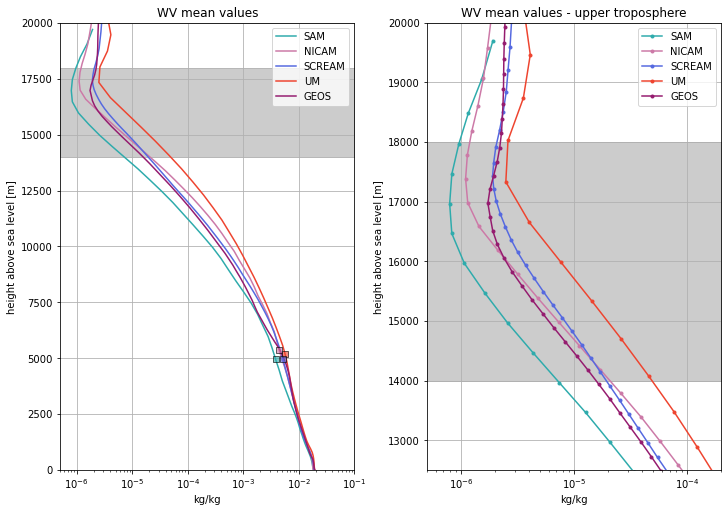

In [27]:
fig, [ax, axt] = plt.subplots(1,2, figsize=(10,7), constrained_layout=True)
m="SAM"
z = "z"
(hus_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(hus_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="NICAM"
z = "lev"
(hus_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(hus_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="SCREAM"
z = "lev"
ax.plot((hus_dict[m])[:-1], z_sc, color=colors[m], label=m)
axt.plot((hus_dict[m])[:-1], z_sc, color=colors[m], label=m, marker=".")
m="UM"
ax.plot(hus_dict[m][:-1], z_um, color=colors[m], label=m)
axt.plot(hus_dict[m][:-1], z_um, color=colors[m], label=m, marker=".")
m="GEOS"
ax.plot(hus_dict[m], z_ge, color=colors[m], label=m)
axt.plot(hus_dict[m], z_ge, color=colors[m], label=m, marker=".")


ax.scatter(hus_dict["UM"][i_um], z_um[i_um], color=colors["UM"], marker="s",
           alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(hus_dict["NICAM"][i_ni], clw_dict["NICAM"].lev[i_ni], marker="s",
           color=colors["NICAM"], alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(hus_dict["SAM"][i_sa], clw_dict["SAM"].z[i_sa], color=colors["SAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(hus_dict["SCREAM"][i_sc], z_sc[i_sc], color=colors["SCREAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)

ax.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)
axt.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)

ax.legend(loc="upper right")
axt.legend(loc="upper right")
ax.set_xscale("log")
axt.set_xscale("log")
ax.set_xlim([5e-7,1e-1])
ax.set_ylim([0,20000])
axt.set_xlim([5e-7,2e-4])
axt.set_ylim([12500,20000])
axt.set_title("WV mean values - upper troposphere")
axt.set_xlabel("kg/kg")
ax.set_title("WV mean values")
ax.set_xlabel("kg/kg")
ax.grid(True)
axt.grid(True)
plt.savefig("../plots/TWP/TWP_3D_hus_mean.png", dpi=120)
plt.show()

## Relative humidity


In [10]:
var_key = "rh_ice"
var = big_dict[var_key]

fig, [ax, axt] = plt.subplots(1,2, figsize=(10,7), constrained_layout=True)

# m="SAM"
# z = "z"
# (var[m]).plot(y=z, ax=ax, color=colors[m], label=m)
# (var[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
# m="NICAM"
# z = "lev"
# (var[m]).plot(y=z, ax=ax, color=colors[m], label=m)
# (var[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="SCREAM"
z = "lev"
ax.plot((var[m])[:-1], z_sc, color=colors[m], label=m)
axt.plot((var[m])[:-1], z_sc, color=colors[m], label=m, marker=".")
m="UM"
ax.plot(var[m][:-1], z_um, color=colors[m], label=m)
axt.plot(var[m][:-1], z_um, color=colors[m], label=m, marker=".")

ax.scatter(var["UM"][i_um], z_um[i_um], color=colors["UM"], marker="s",
           alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(var["NICAM"][i_ni], clw_dict["NICAM"].lev[i_ni], marker="s",
           color=colors["NICAM"], alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(var["SAM"][i_sa], clw_dict["SAM"].z[i_sa], color=colors["SAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(var["SCREAM"][i_sc], z_sc[i_sc], color=colors["SCREAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)

ax.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)
axt.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)

ax.legend(loc="upper right")
axt.legend(loc="upper right")
ax.set_xscale("log")
axt.set_xscale("log")
ax.set_xlim([5e-7,1e-1])
ax.set_ylim([0,20000])
axt.set_xlim([5e-7,2e-4])
axt.set_ylim([12500,20000])
axt.set_title("{} mean values - upper troposphere".format(var_key))
axt.set_xlabel(units[var_key])
ax.set_title("{} mean values".format(var_key))
ax.set_xlabel(units[var_key])
ax.grid(True)
axt.grid(True)
plt.savefig("../plots/TWP/TWP_3D_{}_mean.png".format(var_key), dpi=120)
plt.show()

KeyError: 'rh_ice'

In [7]:
# Test out TTL IWC for GT

ds = xr.open_dataset(ap.get_file("SCREAMr0.25deg","GT_14-18km","ttliwc"), chunks={"time":60,"lat":60,"lon":100}).hus
ds

,Array,Chunk
Bytes,5.87 GiB,26.09 MiB
Shape,"(240, 240, 19, 1440)","(60, 60, 19, 100)"
Count,241 Tasks,240 Chunks
Type,float32,numpy.ndarray


In [10]:
dsmean = ds.mean(dim=["time","lat","lon"])

[########################################] | 100% Completed |  2min 56.9s


AttributeError: module 'matplotlib.pyplot' has no attribute 'invert_yaxis'

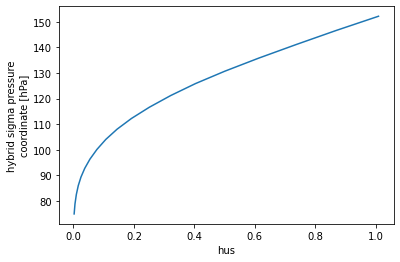

In [12]:
dsmean.plot(y="lev")
plt.invert_yaxis()
plt.xscale("log")
plt.show()